## i'm investigating 2 changes here. first is a dummy var for having or not having sparse vars (alley and miscfeature). second i'll try to change overallcond and overallqual to 3 ranked ladder

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%pylab inline

train = pd.read_csv('../data/train.csv')

train=train[train.GrLivArea<4000]
train=train[train.LotArea<100000]
train.drop(['HouseStyle','BldgType','GarageCars','Utilities'], axis=1, inplace=True)

cut_out=train.columns[train.count().values<0.1*len(train)].tolist()
cut_out

Populating the interactive namespace from numpy and matplotlib


['Alley', 'PoolQC', 'MiscFeature']

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


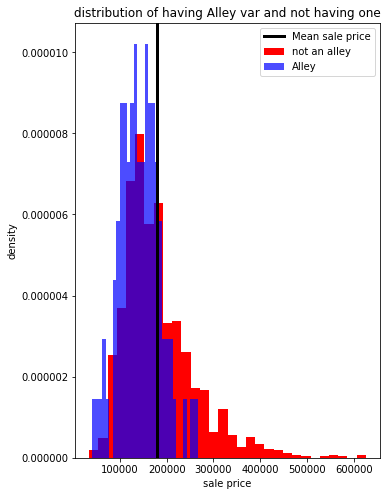

In [2]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.hist(train[train.Alley.isnull()].SalePrice,bins=30, color='r', density=True,label='not an alley')
ax.hist(train[train.Alley.notnull()].SalePrice,bins=30, color='b',density=True,alpha=0.7,label='Alley')
ax.axvline(train.SalePrice.mean(), color='k',label='Mean sale price', linewidth=3)
ax.set_title('distribution of having Alley var and not having one')
ax.set_xlabel('sale price')
ax.set_ylabel('density')
ax.legend(loc=0)
fig.show()

we can see that houses that have "Alley" var are usually cheaper. thats good!

In [3]:
train[train.PoolQC.notnull()].Id.count()

5

there are only 5 houses with poolQC not beeing null. lets see how many houses with pool there are

In [4]:
train[train.PoolArea>0].loc[:,['PoolArea','PoolQC']]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1386,519,Fa
1423,738,Gd


we see there are only 5 pool's in our train data. we will leave it for now.

In [5]:
train[train.MiscFeature.notnull()].Id.count()

52

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


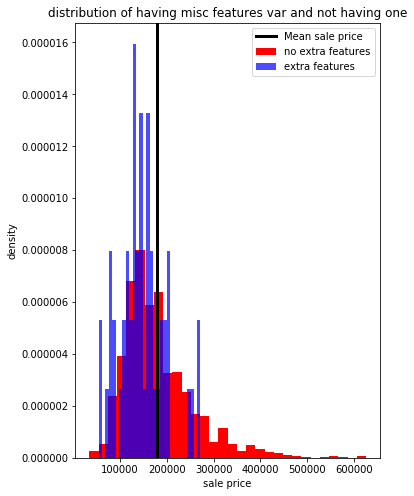

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.hist(train[train.MiscFeature.isnull()].SalePrice,bins=30, color='r', density=True,label='no extra features')
ax.hist(train[train.MiscFeature.notnull()].SalePrice,bins=30, color='b',density=True,alpha=0.7,label='extra features')
ax.axvline(train.SalePrice.mean(), color='k',label='Mean sale price', linewidth=3)
ax.set_title('distribution of having misc features var and not having one')
ax.set_xlabel('sale price')
ax.set_ylabel('density')
ax.legend(loc=0)
fig.show()

once again it seems there is a correlation between this var and having lower price

In [7]:
fix1=train[train.Exterior2nd=='Brk Cmn'].index.tolist()
train.loc[fix1,'Exterior2nd']='BrkComm'

fix2=train[train.Exterior2nd=='Wd Shng'].index.tolist()
train.loc[fix2,'Exterior2nd']='WdShing'

fix3=train[train.Exterior2nd=='CmentBd'].index.tolist()
train.loc[fix3,'Exterior2nd']='CemntBd'

train['Diff_in_Ext']=train.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

map_overall_to_cat={10:'High',9:'High',8:'High',7:'Average',6:'Average',5:'Average',4:'Average',
                    3:'Low',2:'Low',1:'Low'}

train.OverallCond=train.OverallCond.map(map_overall_to_cat)
train.OverallQual=train.OverallQual.map(map_overall_to_cat)

cat_c=[]
for c in train.columns.tolist():
    if train[c].dtypes=='int64' or train[c].dtypes=='float64':
        continue
    else:
        cat_c.append(c)
cat_c.remove('MSZoning')
#cat_c.remove('Alley')
#cat_c.remove('MiscFeature')

def make_dummies_conditional_on_len(train,c):
    df=train.groupby(c).Id.count()
    for i in df.index.tolist():
        if df.loc[i]>=50:
            name=str(c)+'_'+str(i)
            train[name]=np.where(train[c]==i,1,0)
    train.drop(c,axis=1, inplace=True)

for c in cat_c:
    make_dummies_conditional_on_len(train,c)

train.drop(['SaleType_New', 'CentralAir_Y','LandSlope_Gtl' ,'BsmtFinType2_Unf',
            'Foundation_PConc','RoofStyle_Gable', 'PavedDrive_Y','Electrical_SBrkr'], axis=1,inplace=True)


train.shape

(1452, 106)

In [8]:
'''train['Some_Alley']=0
train.loc[:,'Some_Alley'][train.Alley.notnull()]=1

train['Some_Extra_Features']=0
train.loc[:,'Some_Extra_Features'][train.MiscFeature.notnull()]=1

train.drop(['Alley','MiscFeature'],axis=1,inplace=True)

print(train.Some_Alley.sum(),train.Some_Extra_Features.sum())
'''

"train['Some_Alley']=0\ntrain.loc[:,'Some_Alley'][train.Alley.notnull()]=1\n\ntrain['Some_Extra_Features']=0\ntrain.loc[:,'Some_Extra_Features'][train.MiscFeature.notnull()]=1\n\ntrain.drop(['Alley','MiscFeature'],axis=1,inplace=True)\n\nprint(train.Some_Alley.sum(),train.Some_Extra_Features.sum())\n"

In [9]:
LotFrontage_to_fix=train[train.LotFrontage.isnull()].index.tolist()
train.loc[LotFrontage_to_fix,'LotFrontage']=train.LotFrontage.mean()

MasVnrArea_to_fix=train[train.MasVnrArea.isnull()].index.tolist()
train.loc[MasVnrArea_to_fix,'MasVnrArea']=0

GarageYrBlt_to_fix=train[train.GarageYrBlt.isnull()].index.tolist()
train.loc[GarageYrBlt_to_fix,'GarageYrBlt']=train.GarageYrBlt.mean().round(0)

def turn_MS_data_into_cat(df):
    for i in df.MSSubClass.unique().tolist():
        for j in df.MSZoning.unique().tolist():
            if df[(df.MSSubClass==i)&(df.MSZoning==j)].Id.count()>=20:
                name=str(i)+'_'+str(j)
                df[name]=np.where((df.MSSubClass==i)&(df.MSZoning==j),1,0)
    df.drop(['MSSubClass','MSZoning'], axis=1, inplace=True)
turn_MS_data_into_cat(train)

train.drop('YearBuilt', axis=1, inplace=True)

train.loc[train[train.YearRemodAdd>train.YrSold].index,'YearRemodAdd']=2007

train['Avg_room_size']=train.GrLivArea/train.TotRmsAbvGrd

train=pd.concat([train,pd.get_dummies(train.BedroomAbvGr, prefix="br")], axis=1)
train.drop('br_8', axis=1, inplace=True)

train.shape

(1452, 127)

In [10]:
train['SaleDate']=train.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
train['SaleDate']=pd.to_datetime(train['SaleDate'])

n_transaction=train.groupby('SaleDate').size()
train['n_transaction']=n_transaction.loc[train.SaleDate].values
train['Log_sale_price']=np.log10(train.SalePrice)
train.drop('SalePrice', axis=1, inplace=True)

In [11]:
def backwardElimination(X, Y):
    for i in np.arange(0.9,0,-0.1):
        numVars = len(X.columns.tolist())
        d=[]
        regressor_OLS = sm.OLS(Y, X).fit()
        for j in range(numVars):
            if regressor_OLS.pvalues[j] > i:
                d.append(X.columns[j])
        for t in d:
            X=X.drop(t, axis=1)
    
    regressor_OLS = sm.OLS(Y, X).fit()
    while max(regressor_OLS.pvalues > i):
        numVars = len(X.columns.tolist())
        d=[]
        for j in range(numVars):
            if regressor_OLS.pvalues[j] > i:
                d.append(X.columns[j])
        for t in d:
            X=X.drop(t, axis=1)
        regressor_OLS = sm.OLS(Y, X).fit()
    
    print(regressor_OLS.summary())
    
    return regressor_OLS, X.columns.tolist()

def predicting(train, list_to_remove):
    columns_to_keep=train.columns.tolist()
    for i in list_to_remove:
        columns_to_keep.remove(i)

    X=train[columns_to_keep]
    y=train.Log_sale_price
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    regressor_OLS = sm.OLS(y_train,x_train).fit()
    print(regressor_OLS.summary())
    
    y_pred=regressor_OLS.predict(x_test)
    mse = mean_squared_error(y_pred,y_test)
    rmse = np.sqrt(mse)
    print("\n rmse on all var's is: ", rmse)   
    
    regressor, ctp=backwardElimination(x_train,y_train)
    
    y_pred2=regressor.predict(x_test[ctp])
    mse2 = mean_squared_error(y_pred2,y_test)
    rmse2 = np.sqrt(mse2)
    print("\n rmse on best var's is: ", rmse2)

    return y_pred, y_pred2,y_test,ctp,regressor

def plotting_pred(y_pred,y_test,y_pred2):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,2,1)
    ax.scatter(y_pred,y_test, s=5)
    ax.set_title('prediction of log10 prices')
    ax.set_xlabel('predicted price')
    ax.set_ylabel('real price')

    bx = fig.add_subplot(1,2,2)
    bx.scatter(y_pred2,y_test, s=5)
    bx.set_title('prediction of log10 prices')
    bx.set_xlabel('predicted price')
    bx.set_ylabel('real price')

    fig.show()

In [12]:
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     77.10
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        01:09:42   Log-Likelihood:                 1591.9
No. Observations:                1016   AIC:                            -2940.
Df Residuals:                     894   BIC:                            -2339.
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage           -7.102e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     168.3
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        01:09:43   Log-Likelihood:                 1555.3
No. Observations:                1016   AIC:                            -2999.
Df Residuals:                     960   BIC:                            -2723.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                1.946e-

# once again ill try to submit

In [13]:
test= pd.read_csv('../data/test.csv')

fix_year=test.loc[test.GarageYrBlt>2010].GarageYrBlt.index.values.tolist()
test.loc[fix_year,'GarageYrBlt']=np.nan

fix4=test[test.Exterior2nd=='Brk Cmn'].index.tolist()
test.loc[fix4,'Exterior2nd']='BrkComm'

fix5=test[test.Exterior2nd=='Wd Shng'].index.tolist()
test.loc[fix5,'Exterior2nd']='WdShing'

fix6=test[test.Exterior2nd=='CmentBd'].index.tolist()
test.loc[fix6,'Exterior2nd']='CemntBd'

test.loc[test[test.YearRemodAdd>test.YrSold].index, 'YearRemodAdd']=2007 


test.OverallCond=test.OverallCond.map(map_overall_to_cat)
test.OverallQual=test.OverallQual.map(map_overall_to_cat)
test['Diff_in_Ext']=test.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

for c in cat_c:
    test=pd.concat([test,pd.get_dummies(test[c], prefix=c)], axis=1)

turn_MS_data_into_cat(test)

test=pd.concat([test,pd.get_dummies(test.BedroomAbvGr, prefix="br")], axis=1)

test['temp']=test.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
test['SaleDate']=pd.to_datetime(test['temp'])
test['n_transaction']=n_transaction.loc[test.SaleDate].values

test['120_RM']=0
test['Avg_room_size']=test.GrLivArea/test.TotRmsAbvGrd

test_X=test[ctp]
test_X.loc[:,test_X.isnull().any()].columns.tolist()

KeyError: "['60_FV'] not in index"

In [ ]:
test.loc[test[test.GarageArea.isnull()==True].index.tolist(),'GarageArea']=0
test.loc[test[test.TotalBsmtSF.isnull()==True].index.tolist(),'TotalBsmtSF']=0
test.loc[test[test.BsmtFinSF1.isnull()==True].index.tolist(),'BsmtFinSF1']=0
test.loc[test[test.BsmtFinSF2.isnull()==True].index.tolist(),'BsmtFinSF2']=0
test.loc[test[test.BsmtFullBath.isnull()==True].index.tolist(),'BsmtFullBath']=0

test.iloc[1132].GarageYrBlt=2007
test.iloc[1132].GarageYrBlt=1983
test.loc[test[test.GarageYrBlt.isnull()==True].index.tolist(),'GarageYrBlt']=test.GarageYrBlt.mean().round(0)

test_X=test[ctp]
test_X.loc[:,test_X.isnull().any()].columns.tolist()

In [ ]:
y_pred_test=regressor.predict(test_X)

y_pred_test.isnull().any()

In [ ]:
SalePrice=pd.Series(10**y_pred_test, name='SalePrice')

test=test.join(SalePrice)

submission = test.loc[:, ['Id', 'SalePrice']].copy()
submission.set_index('Id', inplace=True)
submission.head()

In [ ]:
#submission.to_csv('../data/model07.csv')

another small improvment :) i'm now just below 0.14

good news is that we gained better model. bad news is that new features didnt worked. next steps:
1. find ways to make these features work.
2. try to change the conditional treshold from 50 to 20 [didnt work]